In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
from numba_stats import truncnorm, truncexpon, norm, expon

from typing import (
    List,
    Tuple,
    Union,
    Sequence,
    Collection,
    Dict,
    Any,
    Iterable,
    Optional,
    overload,
    TypeVar,
    Callable,
    cast,
)



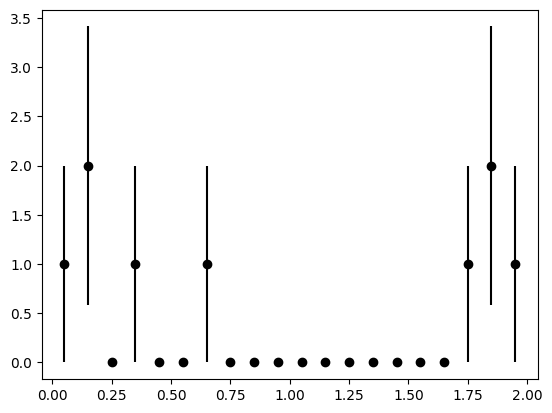

In [2]:
# An example dataset as well as an ensemble of datasets

xr = (0, 2)  # xrange
rng = np.random.default_rng(1)
ensemble_size = 1000
sig_size = 0
bkg_size = 20

example_data = np.array([0.13564805, 0.63742675, 0.0170681,  0.34447481, 1.87700164, 1.84780223, 1.79478165, 0.17158033, 1.90350493])
n, xe = np.histogram(example_data, bins=20, range=xr)
cx = 0.5 * (xe[1:] + xe[:-1])

plt.errorbar(cx, n, n ** 0.5, fmt="ok")

sig_data = rng.normal(1, 0.1, size=(ensemble_size, sig_size))
bkg_data = rng.exponential(size=(ensemble_size, bkg_size))
if sig_size == 0:
    ensemble_data = bkg_data
else:
    ensemble_data = np.append(sig_data, bkg_data, axis=1)

In [3]:
# The PDF

def pdf(x, z, mu, sigma, tau):
    return (z * truncnorm.pdf(x, *xr, mu, sigma) +
            (1 - z) * truncexpon.pdf(x, *xr, 0.0, tau))



# 1. The naive implementation of the unbinned NLL. 

First an example and then a look at performance for an ensemble of datasets.


In [4]:

class myUnbinnedNLL(cost.UnbinnedNLL):

    def __init__(self, x, pdf):
        super().__init__(x, pdf)
    
    def _value(self, args: Sequence[float]) -> float:
        f = self._eval_model(args)
        if self._log:
            return -2.0 * np.sum(f)
        return -2.0 * np.sum(np.log(f))
 
def singlefit(c, data, pdf):
    data = data[(xr[0] < data) & (data < xr[1])]
    m = Minuit(c(data, pdf), z=0.3, mu=1, sigma=0.1, tau=1)
    m.fixed["mu", "sigma"] = True
    m.limits["tau"] = (0, None)
    m.migrad()
    return m

c = myUnbinnedNLL


In [5]:

singlefit(c, example_data, pdf)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1637                      │              Nfcn = 423              │
│ EDM = 0.000336 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │  -6.1e39  │  0.4e39   │            │            │         │         │       │
│ 1 │ mu    │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 2 │ sigma │   0.100   │   0.001   │            │            │         │         │  yes  │
│ 3 │ tau   │  3.54e39  │  0.21e39  │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        z       mu    sigma      tau │
├───────┼─────────────────────────────────────┤
│     z │  1.4e+77        0        0 -0.08e78 │
│    mu │        0        0        0        0 │
│ sigma │        0        0        0        0 │
│   tau │ -0.08e78        0        0 4.64e+76 │
└───────┴─────────────────────────────────────┘

In [6]:
def ensemblefit(c, pdf):
    zvals = []
    status = []
    for data in ensemble_data:
        m = singlefit(c, data, pdf)
        zvals.append(m.values['z'])
        status.append(m.valid)
    return np.array(zvals), np.array(status)

def ensembleplot(zvals, status):
    n, xe = np.histogram(zvals[status], bins=50)
    cx = 0.5 * (xe[1:] + xe[:-1])

    fig, ax = plt.subplots()

    ax.errorbar(cx, n, n ** 0.5, fmt="ok")
    fig.text(0.50, 1.00, f'{100*np.sum(status)/len(status):.0f}% of fits succeeded', horizontalalignment='center')
    ax.set_xlabel("z")
    fig.tight_layout()


/tmp/ipykernel_82037/4152880269.py:10: RuntimeWarning: invalid value encountered in log
  return -2.0 * np.sum(np.log(f))


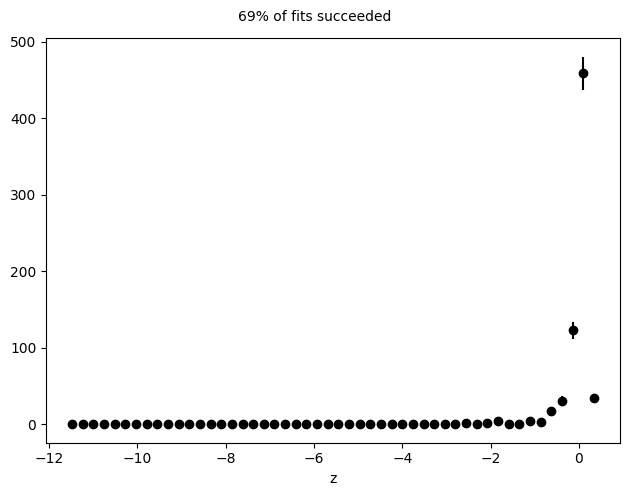

In [7]:
zvals, status = ensemblefit(c, pdf)
ensembleplot(zvals, status)
plt.show()

# 2. Protect against taking logs of negative numbers

If the lilihood of a given event is negative, just replace the likelihood by the smallest possible number. This improves the number of successful fits but has the problem that we allow for unphysical values of the signal component (and which ones we allow for depend on the data).


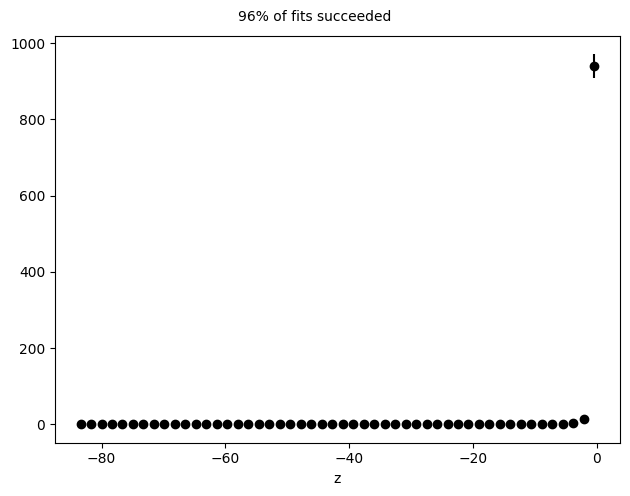

In [8]:
_TINY_FLOAT = np.finfo(float).tiny

class myUnbinnedNLL_no_negative(cost.UnbinnedNLL):

    def __init__(self, x, pdf):
        super().__init__(x, pdf)
    
    def _value(self, args: Sequence[float]) -> float:
        f = self._eval_model(args)
        if self._log:
            return -2.0 * np.sum(f)
        return -2.0 * np.sum(np.log(np.maximum(_TINY_FLOAT, f)))

c = myUnbinnedNLL_no_negative

zvals, status = ensemblefit(c, pdf)
ensembleplot(zvals, status)
plt.show()

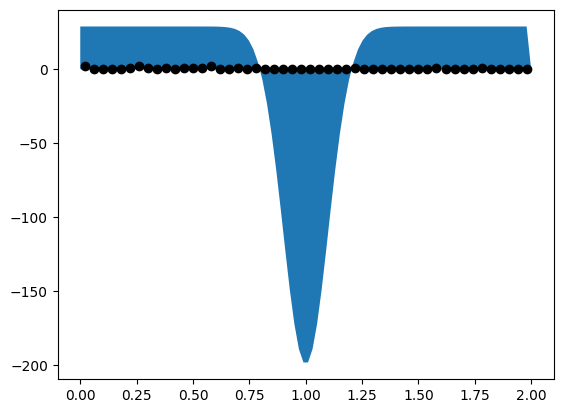

In [9]:
# Find the index of the minimal number in zvals where status is True. So show a bad example that still succeeded
min_index = np.argmin(zvals[status])
m = singlefit(c, ensemble_data[status][min_index], pdf)

m.visualize(model_points=np.linspace(*xr, 100))


# 3. Protect against negative parts of signal pdf.

This will only work if the valid region can be mapped onto an infinite interval in all fit variables. For a single variable, this is what Minuit does internally when you put limits on a fit variable. It can be seen here that the fits gets stuck at the limit and make no sense.


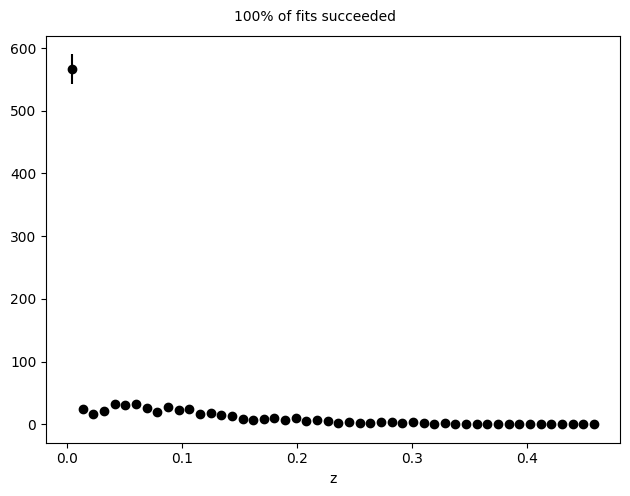

In [10]:
# The modified PDF

def pdflimit(x, z, mu, sigma, tau):
    zprime = (1 + np.tanh(z)) / 2
    return (zprime * truncnorm.pdf(x, *xr, mu, sigma) +
            (1 - zprime) * truncexpon.pdf(x, *xr, 0.0, tau))


c = myUnbinnedNLL

zvals, status = ensemblefit(c, pdflimit)
zprimevals = (1 + np.tanh(zvals)) / 2
ensembleplot(zprimevals, status)
plt.show()

# 4. Push fitter back to physical region

Allow fit to go outside physical region, but ensure that the NLL will always increase rapidly as we move away from boundary. In first example make sure that we know where the boundary is analytically.


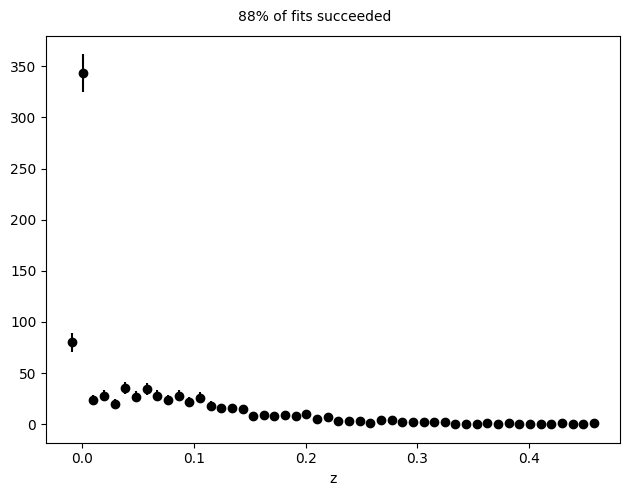

In [11]:
class myUnbinnedNLL_push(cost.UnbinnedNLL):

    def __init__(self, x, pdf):
        super().__init__(x, pdf)
    
    def _value(self, args: Sequence[float]) -> float:
        penalty = 0
        if args[0] < 0:
            penalty = args[0]**2
            args = (0,) + args[1:]
        if args[0] > 1:
            penalty = (args[0]-1)**2
            args = (1,) + args[1:]
        f = self._eval_model(args)
        if self._log:
            return -2.0 * np.sum(f)
        return -2.0 * np.sum(np.log(np.maximum(_TINY_FLOAT, f))) + penalty

c = myUnbinnedNLL_push

zvals, status = ensemblefit(c, pdf)
ensembleplot(zvals, status)
plt.show()

# 5. Unknown boundary

Try to deal with the situation where we do not know where the boundary is. This means that we numerically explore if the signal pdf is negative anywhere.


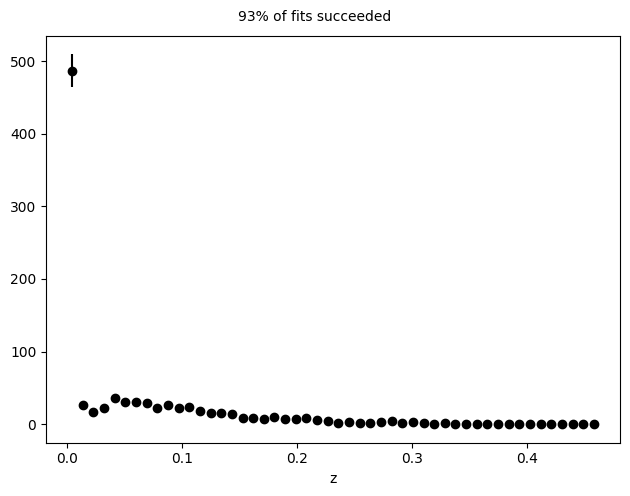

In [12]:
class myUnbinnedNLL_unknown(cost.UnbinnedNLL):

    def __init__(self, x, pdf):
        self._first = True
        super().__init__(x, pdf)
    
    def _value(self, args: Sequence[float]) -> float:
        penalty = 0
        if self._first:
            self._first = False
            self._oldargs = args
            f = self._eval_model(args)
            return -2.0 * np.sum(np.log(np.maximum(_TINY_FLOAT, f)))
        else:
            # Determine if pdf is negative anywhere in the interval xr
            num_points = 1000
            x_values = np.linspace(xr[0], xr[1], num_points)
            pdf_values = args[0] * truncnorm.pdf(x_values, *xr, args[1], args[2])

            if np.any(pdf_values < 0):
                f = self._eval_model(self._oldargs)
                penalty = 10000*((args[0]-self._oldargs[0])**2 + (args[1]-self._oldargs[1])**2 + (args[2]-self._oldargs[2])**2)
            else:
                self._oldargs = args
                f = self._eval_model(args)
        return -2.0 * np.sum(np.log(np.maximum(_TINY_FLOAT, f))) + penalty

c = myUnbinnedNLL_unknown

zvals, status = ensemblefit(c, pdf)
ensembleplot(zvals, status)
plt.show()